In [1]:
from road_det_filt_adv import initialize_model, convert_pc, grid_sample, fit_surface_ransac, draw_points
import open3d as o3d
import cv2
import CSF
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

/home/vladislav/miniconda3/envs/pointcept/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def procceed(pcd_file, img_file):
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)

    # Load and filter point cloud
    points = np.fromfile(pcd_file, dtype=np.float32).reshape(-1, 4)
    points[:,:3] = convert_pc(points[:,:3], [-12.85, 7.85], [-60, 60], points.shape[0] // 480)
    points = points[points[:, 0] > 0]  # Remove points with x <= 0

    # Ground segmentation using CSF
    csf = CSF.CSF()
    csf.params.bSloopSmooth = False
    csf.params.cloth_resolution = 0.5
    csf.params.rigidness = 3
    csf.setPointCloud(points[:, :3])
    ground, non_ground = CSF.VecInt(), CSF.VecInt()
    csf.do_filtering(ground, non_ground)
    
    ground_idx = np.array(ground)
    non_ground_idx = np.array(non_ground)

    ground_mask = np.zeros(len(points),dtype=bool)
    ground_mask[ground_idx] = True


    tree = KDTree(points[:, :2])  # Only use (X, Y) for search

    curb_threshold = 0.05 # Height difference to detect curbs
    curb_idxs = []

    for i, pt in zip(ground_idx, points[ground_idx]):
        # Find neighbors within 0.5m radius
        idx = tree.query_ball_point(pt[:2], 0.6)
        neighbors = points[idx]

        # Compute height difference with neighbors
        height_diff = np.max(neighbors[:,2]) - np.min(neighbors[:,2])

        if height_diff > curb_threshold:
            curb_idxs.append(i)

    curb_init_idxs = np.array(curb_idxs)
    ground_mask[curb_init_idxs] = False
    img_proj = draw_points(img, points[ground_mask, :3], np.array([[0.,0.,255.]]*np.count_nonzero(ground_mask)))
    img_proj = draw_points(img_proj, points[curb_init_idxs, :3], np.array([[255.,0.,0.]]*len(curb_init_idxs)))

    plt.imshow(img_proj)

[0] Configuring terrain...
[0]  - bbMin: 1.64333 -10.3901 -62.1634
[0]  - bbMax: 123.459 8.43553 105.887
[0] Configuring cloth...
[0]  - width: 247 height: 340
[0] Rasterizing...
[0] Simulating...
[0] Configuring terrain...
[0]  - bbMin: 1.45685 -16.4119 -80.837
[0]  - bbMax: 117.377 1.70666 51.7733
[0] Configuring cloth...
[0]  - width: 235 height: 269
[0] Rasterizing...
[0] Simulating...
[0] Configuring terrain...
[0]  - bbMin: 1.33759 -4.55602 -4.35719
[0]  - bbMax: 125.057 4.98317 30.5068
[0] Configuring cloth...
[0]  - width: 251 height: 73
[0] Rasterizing...
[0] Simulating...
[0] Configuring terrain...
[0]  - bbMin: 0.365184 -13.0259 -90.2899
[0]  - bbMax: 127.81 3.18309 65.782
[0] Configuring cloth...
[0]  - width: 258 height: 316
[0] Rasterizing...
[0] Simulating...


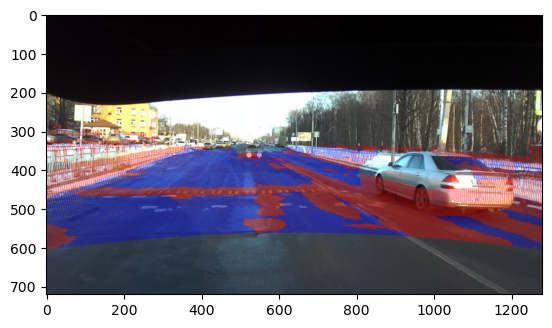

In [3]:
segmodel, seg_head = initialize_model()
pcd_files = ["../Huawei/special_cases/flat/000000.bin", "../Huawei/special_cases/pothole/000000.bin", "../Huawei/special_cases/unpaved/000000.bin", "../Huawei/special_cases/speedbump/000000.bin"]
img_files = ["../Huawei/special_cases/flat/000000.png", "../Huawei/special_cases/pothole/000000.png", "../Huawei/special_cases/unpaved/000000.png", "../Huawei/special_cases/speedbump/000000.png"]
cnt = 0
for pcd_file, img_file in zip(pcd_files, img_files):
    procceed(pcd_file, img_file)
    plt.savefig(f"{cnt}.png")
    cnt+=1